# Benchmarks Results

In [2]:
import os
os.chdir("..")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.losses.numpy import smape
from datasetsforecast.m3 import M3    
from neuralforecast.losses.pytorch import SMAPE
import hydra
from omegaconf import DictConfig


## models
from neuralforecast.auto import AutoDeepAR, AutoNBEATS, AutoNHITS, AutoTFT, AutoTCN, AutoRNN, AutoLSTM

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-11 23:01:26,108	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-11 23:01:26,288	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
import run_exp as utils
from ray import tune

dic: DictConfig = DictConfig({
    'directory': './data/m3',
    'group': 'Monthly',
})

Y_all = utils.load_dataset('m3_monthly', dic)

# horizons: list = [i for i in range(1, 2)]
horizons: list = [i for i in range(1, 2)]
results = pd.DataFrame(columns=['model', 'horizon', 'smape'])

models = [
    # AutoDeepAR,
    # AutoNBEATS,
    AutoNHITS,
    # AutoTFT,
    # AutoTCN,
    # AutoRNN,
    # AutoLSTM
]


for model in models:
    for horizon in horizons:
        nhits_config = {
        "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
        "max_steps": tune.choice([1000]),                                         # Number of SGD steps
        "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
        "batch_size": tune.choice([7]),                                           # Number of series in windows
        "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
        "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
        "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
        "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
        "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
        "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
        "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
        "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
        "random_seed": tune.randint(1, 10),
        }

        print(f"Running {model.__name__} with horizon {horizon}")
        model = model(
            h = horizon,
            num_samples = 5,
            loss=SMAPE(),
            config=nhits_config,
        )
        nf = NeuralForecast(
            models=[model],
            freq='M',
        )
        
        Y_hat = nf.cross_validation(df=Y_all, val_size=horizon)
        results = pd.concat([results, pd.DataFrame({
            'model': [model.__class__.__name__],
            'horizon': [horizon],
            'smape': [utils.calculate_smape(Y_hat, Y_hat, model.__class__.__name__)]
        })], ignore_index=True)

2025-02-11 23:35:19,315	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-02-11 23:35:19,330	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/ricar/ray_results/_train_tune_2025-02-11_23-35-10' in 0.0140s.
2025-02-11 23:35:29,437	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/Users/ricar/ray_results/_train_tune_2025-02-11_23-35-10", trainable=...)
2025-02-11 23:35:29,440	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 5 trial(s):
- _train_tune_1f419_00000: FileNotFoundError('Could not fetch metrics for _train_tune_1f419_00000: both result.json and progress.csv were not found at C:/Users/ricar/ray_results/_train_tune_2025-02-11_23-35-10/_train_tune_1f419_00000')
- 

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [12]:
results

model,AutoNHITS
horizon,
1,0.121409


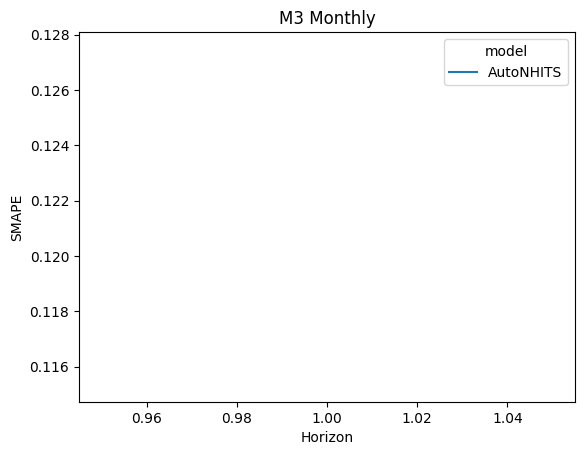

In [11]:
# show results in a graph

results = results.pivot(index='horizon', columns='model', values='smape')
results.plot()
plt.title('M3 Monthly')
plt.ylabel('SMAPE')
plt.xlabel('Horizon')
plt.show()
